# Import packages

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

# Data prepossessing

In [25]:
#read csv files
def read_file(name):
    df=pd.read_csv(name)
    return df

In [26]:
#drop rows that have missing values
def drop_nan(name):
    original_shape=name.shape
    name=name.dropna()
    after_shape = name.shape
    return original_shape, after_shape, name

In [27]:
# Remove duplicate rows and keep the first occurrence
def duplicates(name):
    duplicates = name[name.duplicated()]
    name = name.drop_duplicates(keep='first')
    return duplicates, name

In [28]:
#vused IQR method to handle outlier
def outlier(name):

    numeric_cols = name.select_dtypes(include=['int64', 'float64'])
    Q1 = numeric_cols.quantile(0.25)
    Q3 = numeric_cols.quantile(0.75)
    IQR = Q3 - Q1
    

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply clipping: values lower than the lower bound are set to the lower bound,
    # and values greater than the upper bound are set to the upper bound.
    cleaned_data = numeric_cols.clip(lower=lower_bound, upper=upper_bound, axis=1)
    
    # Replace original numeric columns with the cleaned data
    name[numeric_cols.columns] = cleaned_data
    
    return name

In [29]:
#plot box and check data distribution
def check_outlier(name):

    # Find columns with numerical  data 
    numeric_columns = name.select_dtypes(include=['int64', 'float64'])

    # Get the number of numerical columns
    num_numeric_columns = numeric_columns.shape[1]

    # Creating a figure with 6 subplots (2x3 grid)
    fig, axs = plt.subplots(2, math.ceil(num_numeric_columns/2), figsize=(12, 6))

    # Flattening axs array for easy iteration
    axs = axs.flatten()

    i=0
    for col in numeric_columns.columns:
        sns.boxplot(data=numeric_columns[col], ax=axs[i])
        i=i+1
      

    # Hide unused subplots if there are fewer int64 columns than subplots created
    for j in range(i, len(axs)):
        fig.delaxes(axs[j])

    # Adjusting layout
    plt.tight_layout()
    plt.show()


Processing data/blood_pressure.csv...
Original shape: (721, 8), After dropping NaN: (283, 8)
Number of duplicates found: 0
Outliers handled for data/blood_pressure.csv.
Displaying boxplots for data/blood_pressure.csv:


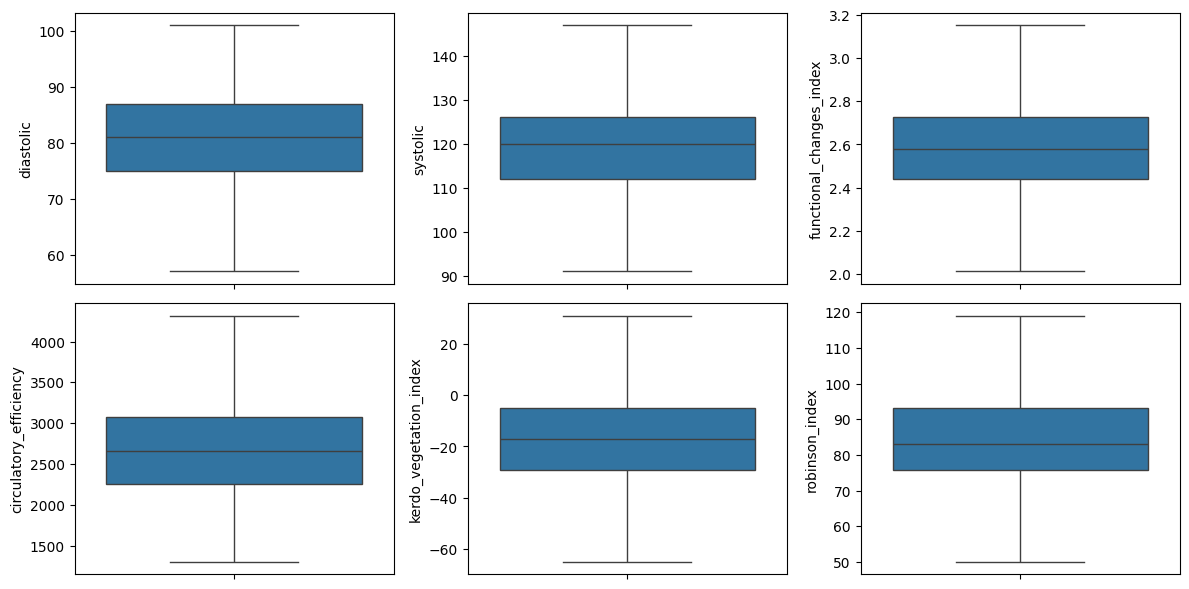

Processing data/heart_rate.csv...
Original shape: (523783, 4), After dropping NaN: (523783, 4)
Number of duplicates found: 0
Outliers handled for data/heart_rate.csv.
Displaying boxplots for data/heart_rate.csv:


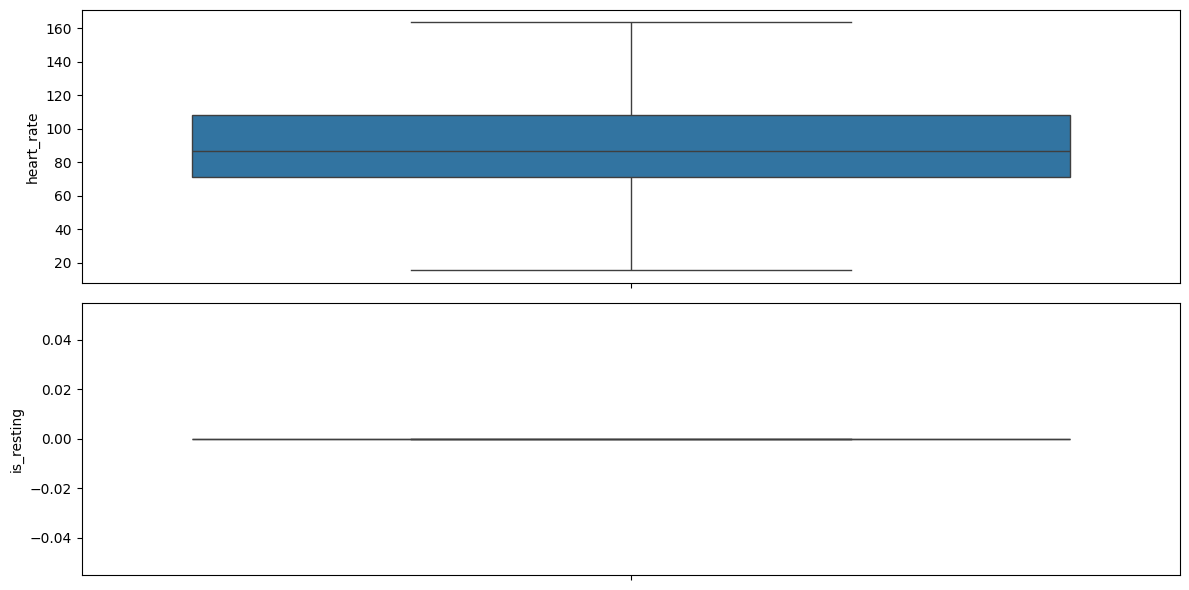

Processing data/hrv_measurements.csv...
Original shape: (3245, 22), After dropping NaN: (924, 22)
Number of duplicates found: 0
Outliers handled for data/hrv_measurements.csv.
Displaying boxplots for data/hrv_measurements.csv:


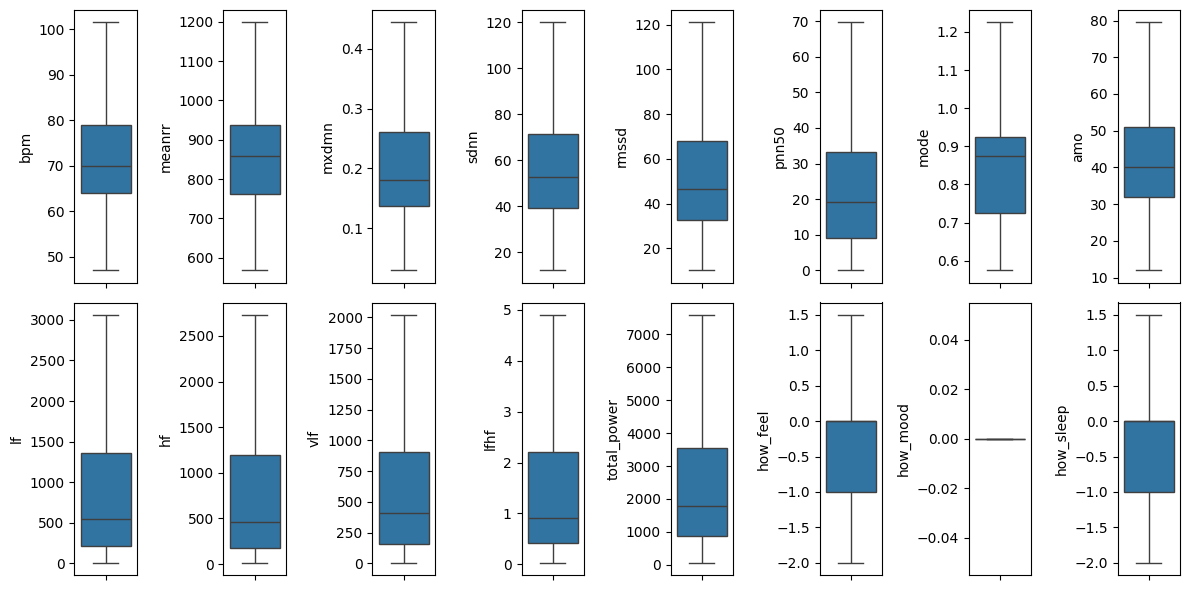

Processing data/participants.csv...
Original shape: (185, 8), After dropping NaN: (136, 8)
Number of duplicates found: 0
Outliers handled for data/participants.csv.
Displaying boxplots for data/participants.csv:


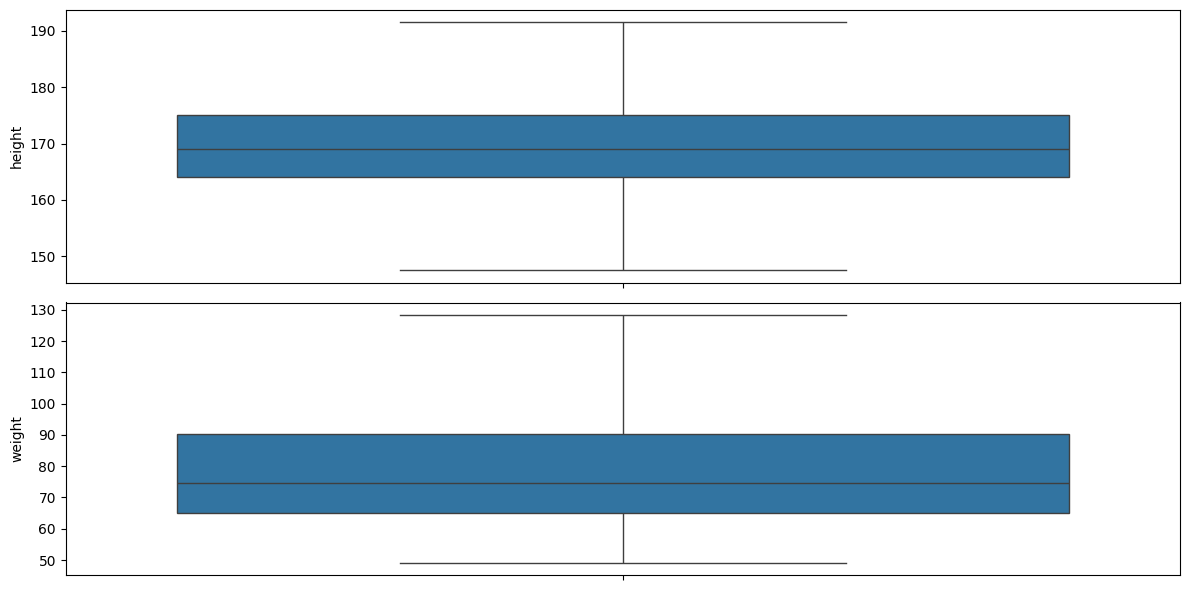

In [30]:
# List of CSV file paths
file_list = ['data/blood_pressure.csv', 'data/heart_rate.csv', 'data/hrv_measurements.csv', 'data/participants.csv']

# Function to process each CSV file
def process_files(file_list):
    processed_files = []
    for file_name in file_list:
        print(f"Processing {file_name}...")
        
        # Step 1: Read the file
        df = read_file(file_name)
        
        # Step 2: Drop NaN values
        original_shape, after_shape, df = drop_nan(df)
        print(f"Original shape: {original_shape}, After dropping NaN: {after_shape}")
        
        # Step 3: Remove duplicates
        duplicates_rows, df = duplicates(df)
        print(f"Number of duplicates found: {duplicates_rows.shape[0]}")
        
        # Step 4: Handle outliers
        df = outlier(df)
        print(f"Outliers handled for {file_name}.")
        
        # Step 5: Check outliers by plotting
        print(f"Displaying boxplots for {file_name}:")
        check_outlier(df)
        
        # Append the cleaned DataFrame to the list of processed files
        processed_files.append(df)
        
    return processed_files

# Process all files
processed_files = process_files(file_list)


# Create new feature

In [31]:
#create a new feature "BMI" in participants.csv
processed_files[3]['BMI']=processed_files[3]['weight']/(processed_files[3]['height']/100)**2
processed_files[3]

,user_code,gender,age_range,city,country,height,weight,symptoms_onset,BMI
1,013f6d3e5b,f,18-24,São Paulo,Brazil,174.00,77.300000,5/15/2020,25.531774
2,01bad5a519,m,45-54,St Petersburg,Russia,178.00,92.000000,4/5/2020,29.036738
3,0210b20eea,f,25-34,Sochi,Russia,169.00,60.000000,5/6/2020,21.007668
4,024719e7da,f,45-54,St Petersburg,Russia,158.00,68.500000,5/27/2020,27.439513
9,0bdfbddb2b,f,18-24,Teren'ga,Russia,159.00,73.500000,4/1/2020,29.073217
...,...,...,...,...,...,...,...,...,...
178,f9edcb7056,f,65-74,Folsom,United States,154.94,128.416875,3/16/2020,53.492758
179,fcf3ea75b0,f,45-54,Moscow,Russia,168.00,92.644000,5/1/2020,32.824546
180,fd387f6269,f,35-44,Attleboro,United States,165.00,115.439000,5/1/2020,42.401837
182,fde84801d8,f,45-54,Tambov,Russia,168.00,79.500000,4/16/2020,28.167517


# Group data by unique user_code and merge

In [32]:
def process_dataframes(processed_files):
    # List to store processed DataFrames
    processed_dfs = []  

    for df in processed_files:
        # Step 1: Drop categorical columns
        numeric_df = df.select_dtypes(include=['int64', 'float64'])
        
        # Step 2: Group by 'user_code' and calculate the mean for numerical columns
        unique_df = numeric_df.groupby(df['user_code']).mean().reset_index()
        
        # Append the processed DataFrame to the list
        processed_dfs.append(unique_df)

    return processed_dfs

In [33]:
processed_files=process_dataframes(processed_files)

In [34]:
# Merge all processed DataFrames on 'user_code'
def merge_dataframes(processed_files):

    # Start with the first processed DataFrame
    final_merged_df = processed_files[0]  
    # Merge the rest
    for processed_file in processed_files[1:]:  
        final_merged_df = final_merged_df.merge(processed_file, on='user_code', how='inner')

    return final_merged_df

In [35]:
# Example usage:
final_result = merge_dataframes(processed_files)

# Display the shape of the final merged DataFrame
print(f"Final Merged DataFrame: Shape = {final_result.shape}")

Final Merged DataFrame: Shape = (12, 28)


In [36]:
#Display rows of the final merged DataFrame
final_result

,user_code,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index,heart_rate,is_resting,bpm,...,hf,vlf,lfhf,total_power,how_feel,how_mood,how_sleep,height,weight,BMI
0,01bad5a519,85.500000,125.500000,2.890625,3361.750000,-1.875000,102.566875,77.360000,0.0,85.500000,...,71.000000,74.166667,1.599333,246.500000,0.000000,0.0,0.000000,178.00,92.000000,29.036738
1,1b9321b648,78.333333,111.666667,2.530000,2750.000000,5.666667,94.400000,83.285714,0.0,79.400000,...,1570.400000,438.200000,0.835600,2969.200000,0.100000,0.0,-0.700000,154.00,67.000000,28.250970
2,1ed25f66e9,64.000000,97.000000,2.012500,2178.000000,3.000000,64.020000,69.200000,0.0,58.000000,...,599.000000,888.000000,3.960000,3859.000000,0.000000,0.0,1.000000,176.00,82.500000,26.633523
3,295ed96279,67.500000,102.750000,2.021250,1890.000000,-25.250000,55.470625,56.379699,0.0,62.937500,...,1192.312500,643.812500,1.224187,2916.937500,-0.062500,0.0,-0.125000,166.00,55.000000,19.959355
4,6be5033971,74.734375,120.765625,2.445937,2828.203125,-22.828125,74.172969,75.341774,0.0,60.244444,...,544.122222,950.933333,2.325892,2723.100000,-0.666667,0.0,-0.488889,164.00,58.500000,21.750446
5,6ecfe4a351,73.666667,110.333333,2.091667,2434.000000,-11.666667,73.543333,150.666982,0.0,78.000000,...,2037.000000,222.000000,0.524000,3326.000000,-2.000000,0.0,-1.000000,167.00,63.000000,22.589551
6,7d2c87fb7e,80.000000,120.000000,2.670000,2720.000000,-18.000000,81.600000,68.000000,0.0,73.000000,...,315.666667,543.333333,2.925042,1600.333333,-0.333333,0.0,-1.666667,183.00,91.500000,27.322404
7,8633d50fa7,98.000000,144.000000,3.152500,3404.000000,-32.000000,106.560000,70.500000,0.0,65.500000,...,342.500000,102.000000,0.767000,681.500000,-0.500000,0.0,0.000000,175.00,92.941000,30.348082
8,9871ee5e7b,82.000000,147.000000,3.152500,4315.500000,22.000000,119.022500,86.709677,0.0,80.090909,...,703.136364,303.545455,1.426545,1918.818182,-0.909091,0.0,-0.818182,178.00,72.660000,22.932711
9,cf7e50bcde,65.166667,99.250000,2.248750,3053.458333,23.916667,88.857500,86.600000,0.0,83.000000,...,1230.500000,134.500000,0.520500,1969.500000,0.500000,0.0,-0.500000,165.00,55.111000,20.242792


In [37]:
final_result.describe()

,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index,heart_rate,is_resting,bpm,meanrr,...,hf,vlf,lfhf,total_power,how_feel,how_mood,how_sleep,height,weight,BMI
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,12.000000,12.000000,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,12.000000,12.000000,12.000000,12.000000
mean,77.301939,116.907938,2.593556,2848.748794,-4.771557,86.644287,81.405593,0.0,73.413174,836.998714,...,966.856717,480.941258,1.459121,2547.642041,-0.358029,0.0,-0.387434,169.078333,78.177406,27.560571
std,9.686394,15.900886,0.438905,643.499912,18.346571,18.140249,23.426874,0.0,9.336344,111.373612,...,810.793510,364.901838,1.091398,1945.917665,0.641158,0.0,0.653832,9.148323,21.262727,8.920879
min,64.000000,97.000000,2.012500,1890.000000,-32.000000,55.470625,56.379699,0.0,58.000000,714.685000,...,71.000000,74.166667,0.478880,246.500000,-2.000000,0.0,-1.666667,154.000000,55.000000,19.959355
25%,72.125000,107.437500,2.209479,2419.935185,-19.207031,74.015560,70.175000,0.0,64.859375,761.476182,...,335.791667,200.125000,0.706250,1393.047619,-0.541667,0.0,-0.729545,164.750000,61.875000,22.379775
50%,76.533854,113.648148,2.600000,2789.101562,-6.381944,89.052569,76.350887,0.0,77.642619,786.516863,...,651.068182,370.872727,1.073332,2346.300000,-0.197917,0.0,-0.339683,167.500000,76.080000,26.977964
75%,82.680556,121.949219,2.956094,3130.531250,6.916667,96.441719,84.114286,0.0,79.572727,929.715937,...,1315.475000,704.859375,1.780973,3058.400000,0.000000,0.0,-0.093750,176.500000,91.625000,28.447412
max,98.000000,147.000000,3.152500,4315.500000,23.916667,119.022500,150.666982,0.0,85.500000,1029.040000,...,2730.500000,1176.280000,3.960000,7589.625000,0.500000,0.0,1.000000,183.000000,128.416875,53.492758


# Data Visualization

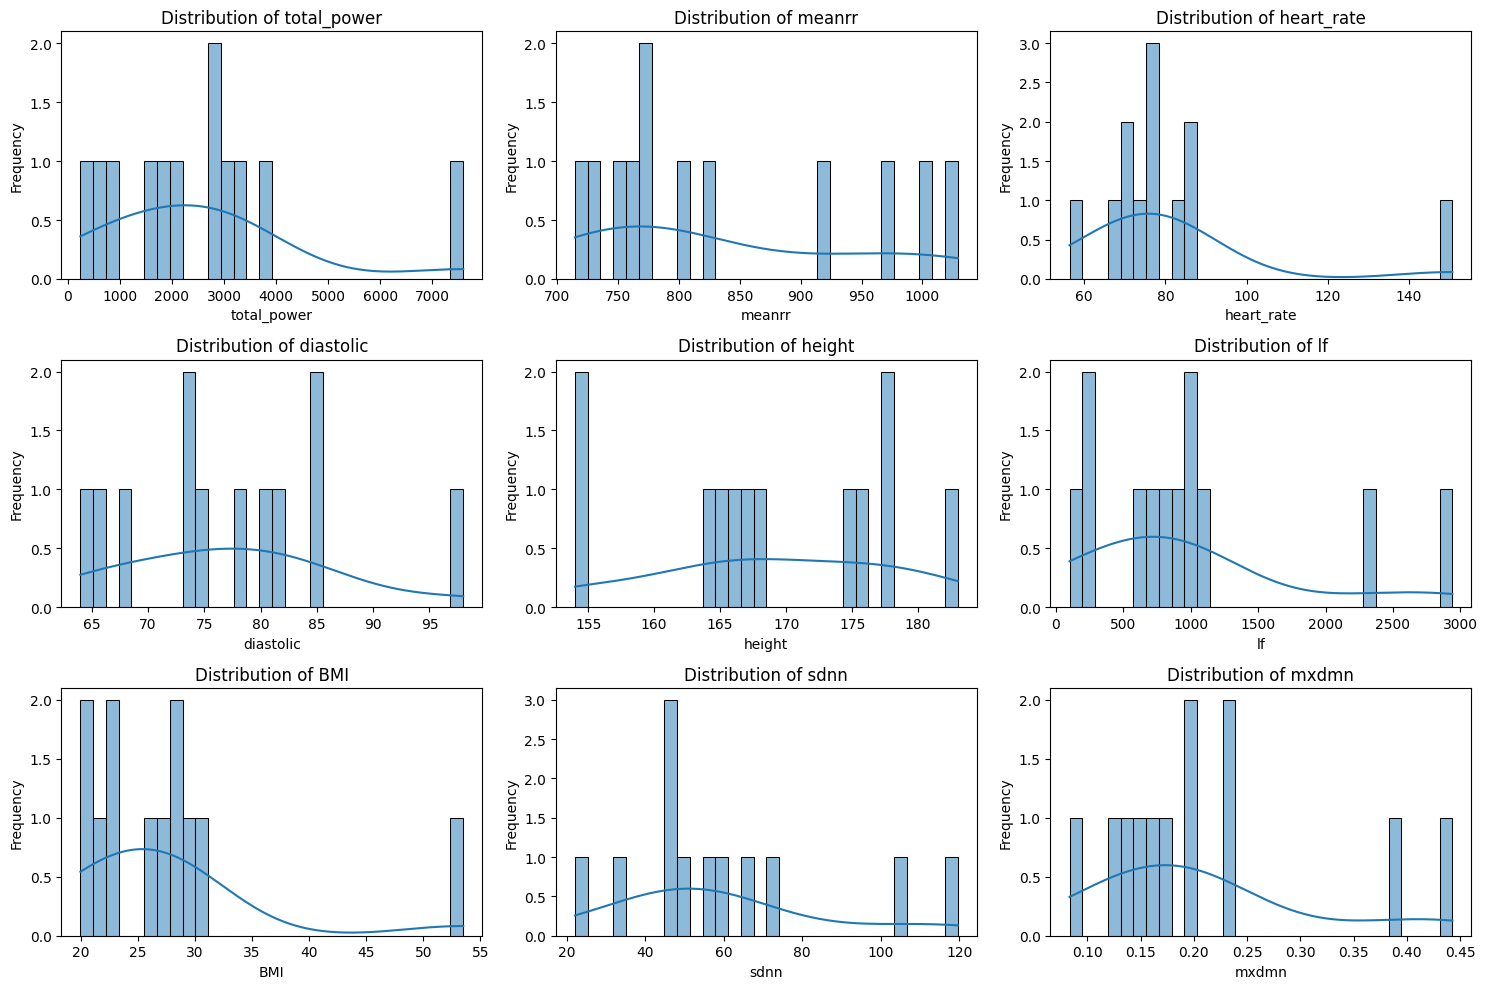

In [38]:
# Randomly select 9 columns
random_columns = random.sample(list(final_result.columns), 9)

# Set up the figure for subplots
plt.figure(figsize=(15, 10))

# Loop through the selected columns and create histograms
for i, column in enumerate(random_columns):
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns
    sns.histplot(final_result[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

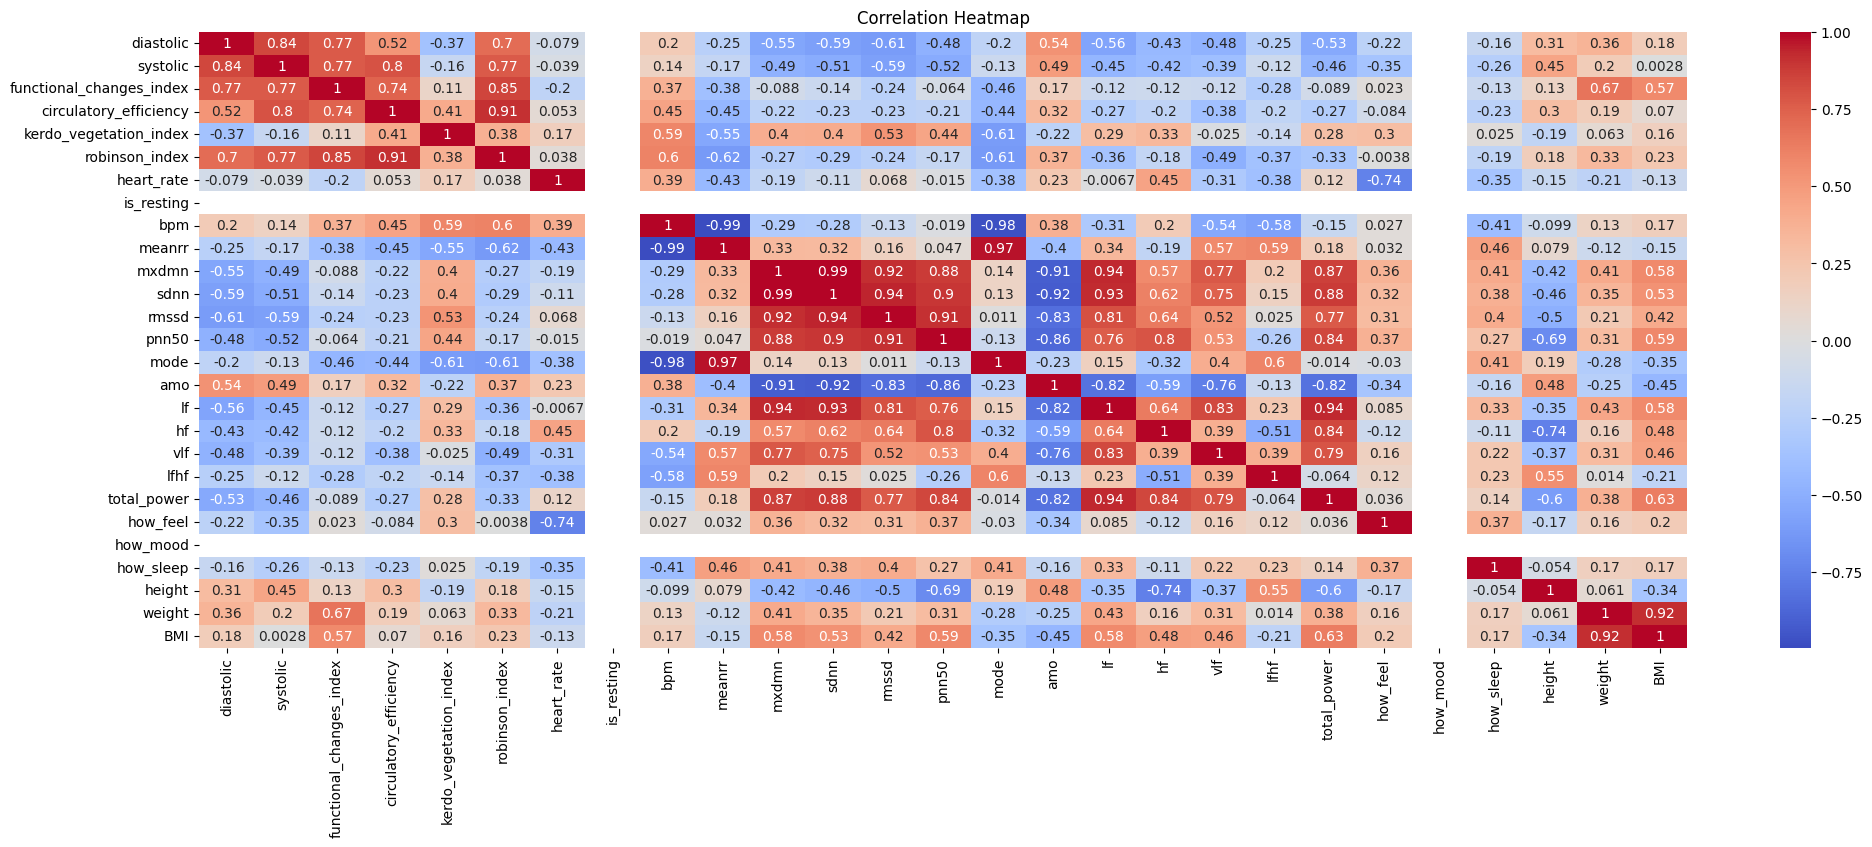

In [39]:
# heatmap of correlations 
final_result_numerical = final_result.drop('user_code', axis=1)
plt.figure(figsize=(24, 8))
sns.heatmap(final_result_numerical.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

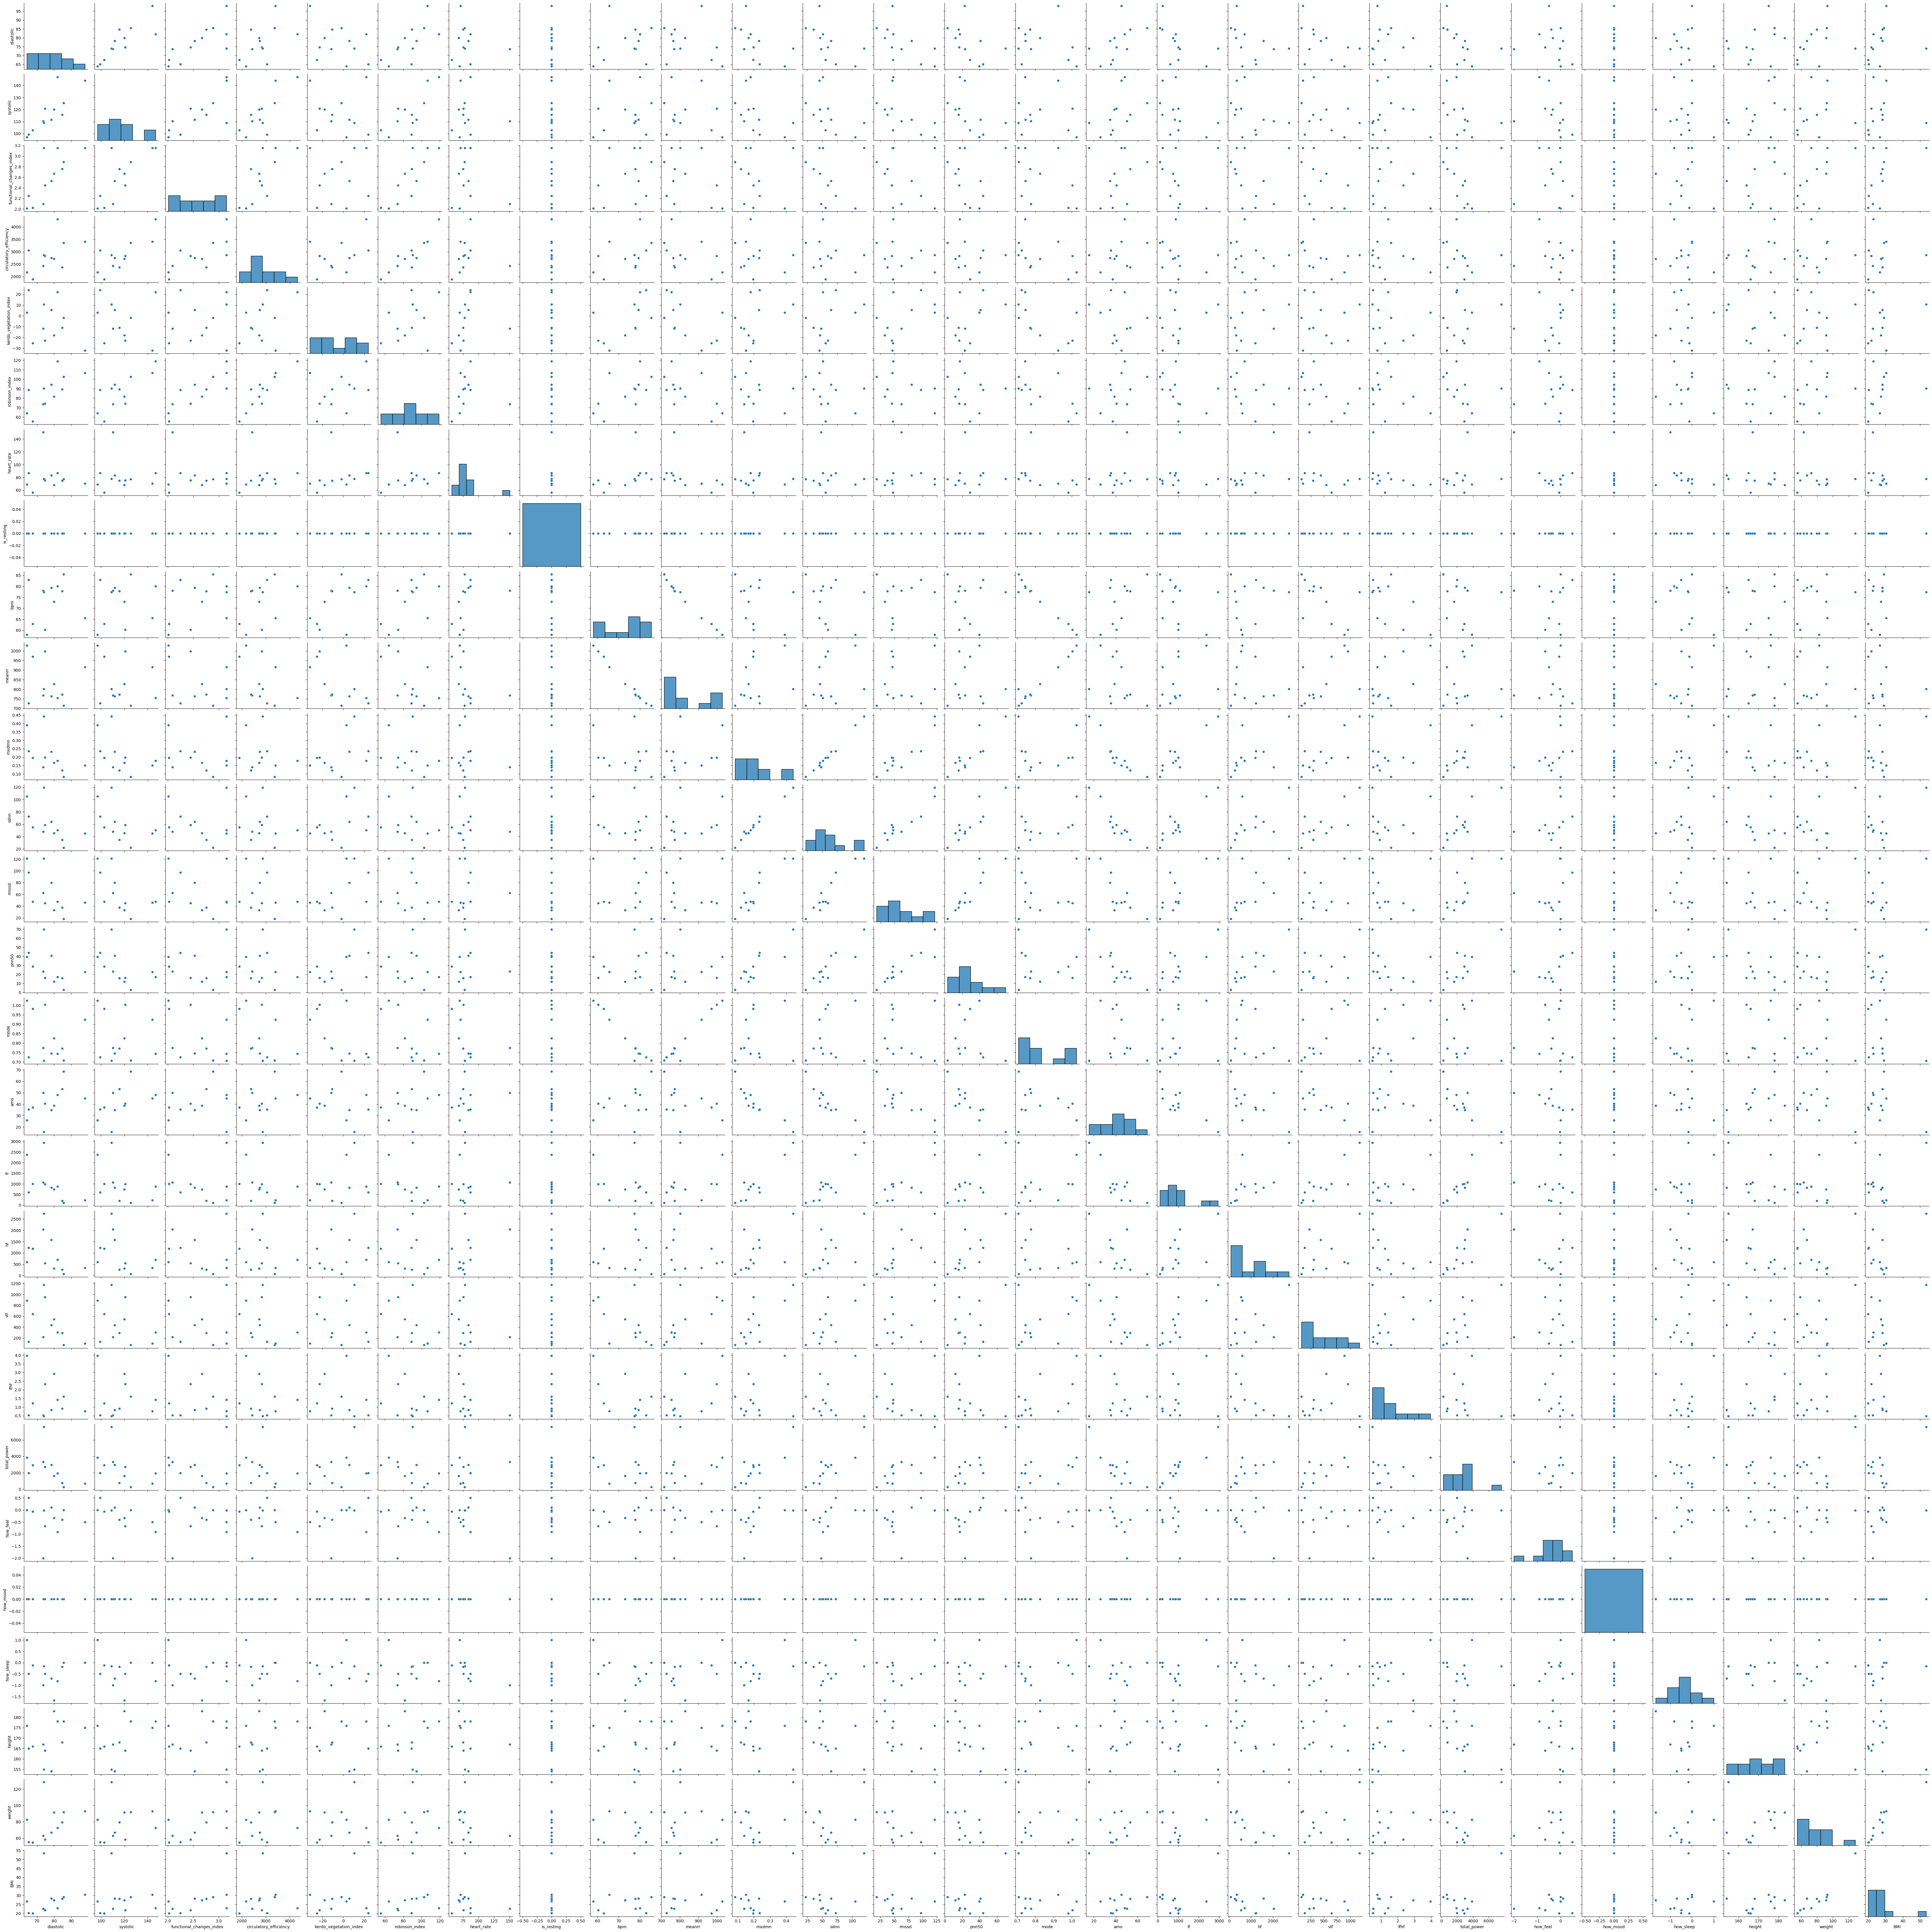

In [23]:
# Use pairplot to visualize the relationships between all numerical variables.
sns.pairplot(final_result_numerical)
plt.show()